<a href="https://colab.research.google.com/github/paulina-radomska/colab-notebooks/blob/main/PaulinaRadomska_SourceCode_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Paulina Radomska

Kod źródłowy do pracy dyplomowej: *Analiza komentarzy użytkowników aplikacji symptom checker z rozpoznawaniem ich intencji*


### Import bibliotek i instalacja pakietów

In [ ]:
#Import wykorzystanych bibliotek i instalacja nowych pakietów.
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt
!pip install app_store_scraper
import app_store_scraper
!pip install google-play-scraper
!pip install emoji --upgrade
import emoji
import re
!pip install contractions
import contractions
!pip install nltk
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
!pip install transformers
import transformers
from transformers import pipeline
from app_store_scraper import AppStore
from google_play_scraper import app
from google_play_scraper import Sort, reviews_all
!pip install evaluate
import evaluate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
!pip install wordcloud
from wordcloud import WordCloud
from collections import Counter
!pip install NRCLex
from nrclex import NRCLex
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download("vader_lexicon")
from sklearn.metrics import accuracy_score, classification_report
import gensim.corpora as corpora
from gensim.models import LdaMulticore
from gensim.models import LdaModel
from pprint import pprint
from gensim.models import FastText
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import RepeatedStratifiedKFold

### Wstępne przygotowanie zbioru danych

In [ ]:
#Pobieranie danych
SC = AppStore(country='us', app_name='symptomate-symptom-checker', app_id = '837725433')
SC.review(how_many=2000)

SCdf = pd.DataFrame(np.array(SC.reviews),columns=['review'])
SCdf = SCdf.join(pd.DataFrame(SCdf.pop('review').tolist()))
SCdf = SCdf[['review', 'title', 'userName', 'rating', 'date']]

us_reviews = reviews_all(
    'com.symptomate.mobile',
    sleep_milliseconds = 0,
    lang = 'en',
    country = 'us',
    sort = Sort.NEWEST,
)
dfSC = pd.DataFrame(np.array(us_reviews),columns=['review'])
dfSC = dfSC.join(pd.DataFrame(dfSC.pop('review').tolist()))
dfSC = dfSC[['content', 'reviewId', 'userName', 'score', 'at']]
dfSC.columns = ['review', 'title', 'userName', 'rating', 'date']
SCreviews = pd.concat([SCdf, dfSC], axis = 0)

In [ ]:
#Usuwanie wierszy z brakującymi komentarzami
SCreviews= SCreviews.dropna(how='any')

In [ ]:
#Sprawdzanie braków danych
pd.isnull(SCreviews).sum()

In [ ]:
#Sprawdzanie typów danych
SCreviews.info()

In [ ]:
#Ustalanie wartości sentymentu
def set_sentiment(row):
    if row["rating"] == 1:
        return "Negative"
    elif row["rating"] == 2:
        return "Negative"
    else:
      return "Positive"

df_clean['energy_category'] = df_clean['energy_%'].apply(categorize_energy)


In [ ]:
#Usuwanie czasu z daty
SCreviews['date'] = pd.to_datetime(SCreviews['date']).dt.normalize()

In [ ]:
#SCreviews['date'].min()
SCreviews['date'].max()

In [ ]:
SCreviews.columns = ['Review', 'Title', 'UserName', 'Rating', 'Date', 'Sentiment']

In [ ]:
sns.countplot(x="Sentiment", data = SCreviews)

In [ ]:
#Liczbowe podsumowanie sentymentów
SCreviews['Sentiment'].value_counts()

In [ ]:
#Liczbowe podsumowanie ocen
SCreviews['Rating'].value_counts()

In [ ]:
rating_count = SCreviews["Rating"].value_counts()
plt.pie(rating_count, labels=rating_count.index, autopct ='%1.1f%%', shadow = True, startangle = 140)
plt.show()

### Transformacje na zbiorze

In [ ]:
#Usuwanie kapitalizacji
SCreviews['Review'] = SCreviews['Review'].str.lower()
SCreviews['Review'] = SCreviews['Review'].astype("string")

In [ ]:
#Usuwanie emoji
SCreviews['Review'] = pd.Series(SCreviews['Review']).apply(lambda x: emoji.demojize(x))

In [ ]:
#Usuwanie szumów
SCreviews['Review'] = pd.Series(SCreviews['Review']).apply(lambda x: re.sub(r'(.)\1+', r'\1\1', x))
SCreviews['Review'] = pd.Series(SCreviews['Review']).apply(lambda x: re.sub(r'[\?\.\!]+(?=[\?\.\!])', "", x))

In [ ]:
#Rozszerzanie skrótów
for row in range(len(SCreviews)):
  SCreviews.iloc[row, 0] = contractions.fix(SCreviews.iloc[row, 0])

In [ ]:
#Usuwanie słów stop
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.remove('not')
stop_words.remove('no')
print(stop_words)

SCreviews['Preprocessed'] = SCreviews['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [ ]:
#Tokenizacja
SCreviews['Tokenized'] = pd.Series(SCreviews['Preprocessed']).apply(lambda x: word_tokenize(x))

In [ ]:
#Lemantyzacja
def get_wordnet_pos(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": wordnet.ADJ,
              "N": wordnet.NOUN,
              "V": wordnet.VERB,
              "R": wordnet.ADV}

  return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

lemmatized = []
for i in range(len(SCreviews)):
  x = [lemmatizer.lemmatize(word,get_wordnet_pos(word)) for word in SCreviews.iloc[i, 7]]
  lemmatized.append(x)

SCreviews["Lemmatized"] = lemmatized

In [ ]:
#Usuwanie znaków interpunkcyjnych
stopwords2 = ['.', ',', ':', '!', '?']
SCreviews["Lemmatized"] = list(filter(lambda w: w not in stopwords2, SCreviews["Lemmatized"]))

In [ ]:
#Otrzymany zbiór danych
SCreviews.head()

,Review,Title,UserName,Rating,Date,Sentiment,Preprocessed,Tokenized,Lemmatized
0,i was putting all my symptoms to check this ou...,Spot on,rinilynn,5,2022-04-23,Positive,putting symptoms check done certain area sympt...,"[putting, symptoms, check, done, certain, area...","[put, symptom, check, do, certain, area, sympt..."
1,"this app, like most doctors, simply do not und...",Can’t Handle Multiple Health Problems,PDF Paul,4,2021-09-10,Positive,"app, like doctors, simply not understand peopl...","[app, ,, like, doctors, ,, simply, not, unders...","[app, ,, like, doctor, ,, simply, not, underst..."
2,i think it will be helpful. way better than do...,It’s useful.,KIMYKASK,5,2021-08-06,Positive,think helpful. way better internet search rand...,"[think, helpful, ., way, better, internet, sea...","[think, helpful, ., way, well, internet, searc..."
3,i will start by saying this is a great app and...,Needs important piece.....,RoBear7496,4,2021-02-22,Positive,start saying great app useful deserves 4 stars...,"[start, saying, great, app, useful, deserves, ...","[start, say, great, app, useful, deserves, 4, ..."
4,i was searching something up and came back to ...,Doesn’t save or have history,attack helicopter with no name,2,2021-12-09,Negative,searching something came back check things sai...,"[searching, something, came, back, check, thin...","[search, something, come, back, check, thing, ..."


In [ ]:
#Wykres osi czasu
SCreviews2 = SCreviews[['Date', 'Sentiment']].copy()
SCreviews2['Positive'] = np.where(SCreviews2['Sentiment'] == 'Positive' , 1, 0)
SCreviews2['Negative'] = np.where(SCreviews2['Sentiment'] == 'Negative' , 1, 0)
SCreviews2['Neutral'] = np.where(SCreviews2['Sentiment'] == 'Neutral' , 1, 0)
result = SCreviews2.groupby(SCreviews2.Date.dt.year).agg({'Positive': 'sum', 'Negative': 'sum', 'Neutral': 'sum'})
plt.plot(result.index, result['Positive'], label = 'Pozytywne')
plt.plot(result.index, result['Negative'], label = 'Negatywne')
plt.plot(result.index, result['Neutral'], label = 'Neutralne')
plt.xlabel('Data', fontsize=10)
plt.ylabel('Liczba recenzji', fontsize=10)
plt.title('Liczba wystawianych recenzji na przestrzeni czasu')
plt.legend()
plt.show()
#plt.savefig("TimelineF.png")

### Analiza częstotliwości słów

In [ ]:
#Ustalanie najczęściej pojawiających się pozytywnych słów
Positives = SCreviews[SCreviews['Sentiment']=='Positive'].reset_index()
all_positive_words=[]

for i in range(len(Positives['Lemmatized'])):
    a=Positives['Lemmatized'][i]

    for i in a:
        all_positive_words.append(i)

all_positive_words=pd.Series(np.array(all_positive_words))

In [ ]:
stopwords2 = ['.', ',', ':', '!', 'app', 'symptom', 'not', 'no', '?']
new_words_positive = list(filter(lambda w: w not in stopwords2, all_positive_words))
print(Counter(new_words_positive).most_common(40))

[('good', 118), ('great', 104), ('use', 70), ('doctor', 63), ('helpful', 59), ('give', 57), ('accurate', 52), ('like', 51), ('diagnosis', 46), ('help', 46), ('easy', 45), (':star-struck', 42), ('get', 41), ('love', 39), ('useful', 37), ('really', 37), ('one', 35), ('need', 35), ('question', 35), ('nice', 34), ('well', 34), ('go', 33), ('work', 31), ('see', 30), ('would', 29), ('say', 27), ('best', 27), (')', 26), ('result', 26), ('thanks', 25), ('health', 24), ('right', 24), ('medical', 24), ('it', 24), ('pretty', 23), ('amaze', 22), ('awesome', 21), ('recommend', 20), ('possible', 19), ('problem', 18)]


In [ ]:
plt.figure(figsize = (20,20))
wc_positive = WordCloud(max_words = 100 , width = 1600 , height = 800,
               collocations=False, background_color="white").generate(" ".join(new_words_positive))
plt.axis("off")
plt.imshow(wc_positive)
#plt.savefig("PositiveWC.png")

In [ ]:
#Ustalanie najczęściej pojawiających się negatywnych słów
Negatives = SCreviews[SCreviews['Sentiment']=='Negative'].reset_index()
all_negative_words=[]

for i in range(len(Negatives['Lemmatized'])):
    a=Negatives['Lemmatized'][i]

    for i in a:
        all_negative_words.append(i)

all_negative_words=pd.Series(np.array(all_negative_words))

new_words_negative = list(filter(lambda w: w not in stopwords2, all_negative_words))
print(Counter(new_words_negative).most_common(40))

[('time', 11), ('like', 11), ('say', 10), ('try', 10), ('give', 10), ('could', 9), ('result', 9), ('get', 9), ('would', 8), ('even', 8), ('can', 8), ('need', 7), ('go', 7), ('waste', 7), ('ask', 7), ('it', 6), ('work', 6), ('question', 6), ('diagnosis', 6), ('add', 6), ('make', 6), ('check', 5), ('many', 5), ('let', 5), ('put', 5), ('useless', 5), ('keep', 5), ('answer', 5), ('suggestion', 5), ('nothing', 5), ('internet', 5), ('suck', 5), ('``', 4), ("''", 4), ('one', 4), ('accurate', 4), ('also', 4), ('list', 4), ('google', 4), ('use', 4)]


In [ ]:
plt.figure(figsize = (20,20))
wc_negative = WordCloud(max_words = 100 , width = 1600 , height = 800,
               collocations=False, background_color="white").generate(" ".join(new_words_negative))
plt.axis("off")
plt.imshow(wc_negative)
#plt.savefig("NegativeWC.png")

In [ ]:
#Ustalanie najczęściej pojawiających się neutralnych słów
Neutrals = SCreviews[SCreviews['Sentiment']=='Neutral'].reset_index()
all_neutral_words=[]

for i in range(len(Neutrals['Lemmatized'])):
    a=Neutrals['Lemmatized'][i]

    for i in a:
        all_neutral_words.append(i)

all_neutral_words=pd.Series(np.array(all_neutral_words))

new_words_neutral = list(filter(lambda w: w not in stopwords2, all_neutral_words))
print(Counter(new_words_neutral).most_common(20))

[('good', 7), ('question', 7), ('use', 6), ('try', 5), ('heart', 5), ('think', 4), ('add', 4), ('pain', 4), ('help', 4), ('result', 4), ('can', 4), ('ask', 4), ('like', 4), ('need', 3), ('update', 3), ('easy', 3), ('seem', 3), ('cancer', 3), ('age', 3), ('well', 3)]


In [ ]:
plt.figure(figsize = (20,20))
wc_neutral = WordCloud(max_words = 100 , width = 1600 , height = 800,
               collocations=False, background_color="white").generate(" ".join(new_words_neutral))
plt.axis("off")
plt.imshow(wc_neutral)
#plt.savefig("NeutralWC.png")

In [ ]:
#Słowa powtarzalne we wszystkich kategoriach sentymentu
new_words_negative=pd.Series(np.array(new_words_negative))
common=set(new_words_positive).intersection(set(new_words_negative)).intersection(set(new_words_neutral))
common_list=list(common)
print(Counter(common_list).most_common(20))

[('%', 1), ('internet', 1), ('many', 1), ('base', 1), ('let', 1), ('provide', 1), ('actually', 1), ('question', 1), ('need', 1), ('time', 1), ('one', 1), ('say', 1), ('like', 1), ('day', 1), ('etc', 1), ('would', 1), ('option', 1), ('specialist', 1), ('go', 1), ('list', 1)]


In [ ]:
plt.figure(figsize = (20,20))
wc_common = WordCloud(max_words = 100 , width = 1600 , height = 800,
               collocations=False, background_color="white").generate(" ".join(common_list))
plt.axis("off")
plt.imshow(wc_common)
#plt.savefig("CommonWC.png")

### Klasyfikacja emocji

In [ ]:
#Klasyfikacja emocji
Words = SCreviews['Lemmatized'].reset_index()
all_words=[]

for i in range(len(Words['Lemmatized'])):
    a=Words['Lemmatized'][i]

    for i in a:
        all_words.append(i)

all_words=pd.Series(np.array(all_words))

In [ ]:
all_words = list(set(all_words))

In [ ]:
for i in range(len(all_words)):
    emotion = NRCLex(all_words[i])
    print('\n\n', all_words[i], ': ', emotion.top_emotions)

In [ ]:
for i in range(len(all_words)):
    affect = NRCLex(all_words[i])
    print('\n\n', affect.affect_dict)

In [ ]:
str_tweet = ','.join(all_words)
text_object = NRCLex(str_tweet)

In [ ]:
#Liczbowe podsumowanie emocji
data = text_object.raw_emotion_scores
data

{'anticipation': 85,
 'fear': 87,
 'surprise': 43,
 'anger': 56,
 'negative': 146,
 'sadness': 68,
 'disgust': 42,
 'positive': 166,
 'joy': 60,
 'trust': 111}

In [ ]:
#Liczbowe podsumowanie emocji w formie tabeli
emotion_df = pd.DataFrame.from_dict(data, orient='index')
emotion_df = emotion_df.reset_index()
emotion_df = emotion_df.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
emotion_df = emotion_df.sort_values(by=['Emotion Count'], ascending=False)
emotion_df = emotion_df.replace(['positive'], 'pozytywne')
emotion_df = emotion_df.replace(['negative'], 'negatywne')
emotion_df = emotion_df.replace(['trust'], 'zaufanie')
emotion_df = emotion_df.replace(['fear'], 'strach')
emotion_df = emotion_df.replace(['anticipation'], 'oczekiwanie')
emotion_df = emotion_df.replace(['joy'], 'radość')
emotion_df = emotion_df.replace(['anger'], 'złość')
emotion_df = emotion_df.replace(['disgust'], 'zniesmaczenie')
emotion_df = emotion_df.replace(['surprise'], 'zaskoczenie')
emotion_df = emotion_df.replace(['sadness'], 'smutek')
emotion_df

In [ ]:
#Wykres klasyfikacji emocji
fig = px.bar(emotion_df, x='Emotion Count', y='Emotion Classification', color = 'Emotion Classification', orientation='h', width = 800, height = 400,
            title="Klasyfikacja emocji", labels={"Emotion Count": "Liczba słów", "Emotion Classification":"Emocje"})
fig.show()
#fig.savefig("EmotionClass.png")

### Model VADER

In [ ]:
#Obliczanie polaryzacji
sentiments = SentimentIntensityAnalyzer()
SCreviews["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in SCreviews["Review"]]
SCreviews["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in SCreviews["Review"]]
SCreviews["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in SCreviews["Review"]]
SCreviews['Compound'] = [sentiments.polarity_scores(i)["compound"] for i in SCreviews["Review"]]

In [ ]:
SCreviews.head()

In [ ]:
SCreviews["Compound"].max()

0.976

In [ ]:
#Przypisanie sentymentu
score = SCreviews["Compound"].values
sentiment = []
for i in score:
    if i >= 0.05 :
        sentiment.append('Positive')
    elif i <= -0.05 :
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
SCreviews["VADER_Sentiment"] = sentiment
SCreviews.head()

In [ ]:
#Wykres oszacowania wyniku złożonego dla każdej oceny
ax = sns.barplot(data=SCreviews, x='Rating', y='Compound')
ax.set_title('Wynik złożony według wystawianych ocen')
ax.set(xlabel = 'Ocena', ylabel = 'Wynik złożony')
#plt.savefig("Compound.png")

In [ ]:
#Wykres oszacowania wyniku złożonego dla każdej oceny i sentymentu
fig, axs = plt.subplots(1,3, figsize=(15,5))
sns.barplot(data=SCreviews, x='Rating', y='Positive', ax=axs[0])
sns.barplot(data=SCreviews, x='Rating', y='Neutral', ax=axs[1])
sns.barplot(data=SCreviews, x='Rating', y='Negative', ax=axs[2])
axs[0].set_title('Sentyment pozytywny')
axs[1].set_title('Sentyment neutralny')
axs[2].set_title('Sentyment negatywny')
axs[0].set(xlabel = 'Ocena', ylabel = 'Wynik złożony')
axs[1].set(xlabel = 'Ocena', ylabel = 'Wynik złożony')
axs[2].set(xlabel = 'Ocena', ylabel = 'Wynik złożony')
plt.tight_layout()
#plt.savefig("Sentiments.png")

In [ ]:
#Wykres punktowy sentymentu
sns.FacetGrid(SCreviews, hue = 'VADER_Sentiment') \
   .map(plt.scatter, "Positive", "Negative", "Neutral") \
   .add_legend(labels = ['Pozytywny', 'Negatywny', 'Neutralny'], title = 'Sentyment')
plt.title('Wykres punktowy przewidywanych sentymentów', fontsize = 12)
plt.xlabel("Wynik pozytwyny")
plt.ylabel("Wynik negatwny")
plt.figsize=(15,15)
plt.show()
#plt.savefig("Scatter.png")

In [ ]:
#Wykres pudełkowy sentymentu
ax= sns.boxplot(x="VADER_Sentiment", y="Compound", data=SCreviews)
ax= sns.stripplot(x="VADER_Sentiment", y="Compound", data=SCreviews, jitter=True, edgecolor="gray")
plt.show()

In [ ]:
#Histogram przewidywań pozytywnych
rslt_df = SCreviews[SCreviews['VADER_Sentiment'] == 'Positive']
sns.displot(rslt_df["Compound"],kde=True)
plt.ylabel("Liczba przewidywań")
plt.xlabel("Wynik złożony")
plt.title("Histogram przewidywań pozytywnych")
plt.show()
#plt.savefig("PosHist.png")

In [ ]:
#Histogram przewidywań negatywnych
rslt_df2 = SCreviews[SCreviews['VADER_Sentiment'] == 'Negative']
sns.displot(rslt_df2["Compound"],kde=True)
plt.ylabel("Liczba przewidywań")
plt.xlabel("Wynik złożony")
plt.title("Histogram przewidywań negatywnych")
plt.show()
#plt.savefig("NegHist.png")

In [ ]:
#Histogram przewidywań neutralnych
rslt_df3 = SCreviews[SCreviews['VADER_Sentiment'] == 'Neutral']
sns.displot(rslt_df3["Compound"],kde=True)
plt.ylabel("Liczba przewidywań")
plt.xlabel("Wynik złożony")
plt.title("Histogram przewidywań neutralnych")
plt.show()
#plt.savefig("NeuHist.png")

In [ ]:
#Liczby poszczególnych ptzewidywań
SCreviews.VADER_Sentiment.value_counts()

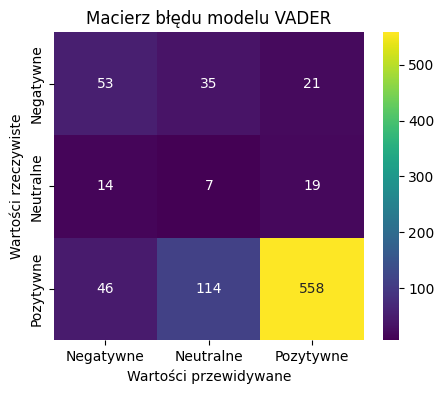

In [ ]:
#Macierz błędu
cm = confusion_matrix(SCreviews['Sentiment'], SCreviews['VADER_Sentiment'])
cm_df = pd.DataFrame(cm,
                     index = ['Negatywne','Neutralne','Pozytywne'],
                     columns = ['Negatywne','Neutralne','Pozytywne'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap = 'viridis')
plt.title('Macierz błędu modelu VADER')
plt.ylabel('Wartości rzeczywiste')
plt.xlabel('Wartości przewidywane')
#plt.show()
plt.savefig("CM_VADER.png")

In [ ]:
#Dokładność i raport klasyfikacji
accuracy = accuracy_score(SCreviews['Sentiment'], SCreviews['VADER_Sentiment'])

print("Accuracy: {}\n".format(accuracy))

print(classification_report(SCreviews['Sentiment'], SCreviews['VADER_Sentiment']))

### Analiza oparta na aspektach

In [ ]:
#Analiza aspektu
df = SCreviews.copy()
df = df[['Review', 'Lemmatized', 'Rating', 'VADER_Sentiment']]

In [ ]:
data_words = df['Lemmatized'].values.tolist()
len(data_words)

867

In [ ]:
#Stworzenie słownika - term document frequency
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1][0][:30])

In [ ]:
#Model LDA
num_topics = 10
lda_model = LdaMulticore(corpus=corpus, id2word=id2word,
                     num_topics=num_topics, iterations=400)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
#Budowa modelu FastText
%%time
fasttext_model = FastText(data_words, vector_size= 100, window=5, min_count=5, workers=4,sg=1)

In [ ]:
fasttext_model.save("FastText-Model-For-ABSA.bin")

In [ ]:
#Zdefiniowanie aspektów i obliczenie podobnieństwa każdego z nich dla poszczególnych recenzji
aspects = ["diagnosis", "symptom", "app", "answer", "question", "doctor"]

def get_similarity(text, aspect):
    try:
        text = " ".join(text)
        return fasttext_model.wv.n_similarity(text, aspect)
    except:
        return 0

In [ ]:
#fasttext_model.wv.n_similarity("great app for everyone", "question")

In [ ]:
tqdm.pandas()
for aspect in aspects:
    df[aspect] = df['Lemmatized'].progress_map(lambda text: get_similarity(text, aspect))

In [ ]:
#Wyznaczenie najbardziej podobnego aspektu
df["Best_aspect"] = df[["diagnosis", "symptom", "app", "answer", "question", "doctor"]].apply(lambda x: x.idxmax(), axis=1)

In [ ]:
def set_aspect_sentiment(row):
    if row["VADER_Sentiment"] == 'Positive':
        return "positively"
    elif row["VADER_Sentiment"] == 'Negative':
        return "negatively"
    elif row["VADER_Sentiment"] == 'Neutral':
        return "neutrally"

df = df.assign(Aspect_sentiment=df.apply(set_aspect_sentiment, axis=1))

In [ ]:
for i in range(len(df)):
  df["Aspect"] = 'The reviewer talks ' + df['Aspect_sentiment'].astype(str) + ' about the ' + df['Best_aspect'].astype(str)
df.head()

In [ ]:
#Podsumowanie liczbowe kazdego aspektu
df['Aspect'].value_counts()

In [ ]:
df_temp = df[['Best_aspect', 'Aspect_sentiment']].copy()
print(df_temp)

In [ ]:
#Utworzenie osobnhych ramek danych dla poszczególnych sentymentów
df_temp_pos = df_temp[df_temp['Aspect_sentiment']=='positively'].reset_index()
df_temp_neg = df_temp[df_temp['Aspect_sentiment']=='negatively'].reset_index()
df_temp_neu = df_temp[df_temp['Aspect_sentiment']=='neutrally'].reset_index()

In [ ]:
#Wykres slupokowy poszczególnych aspektów per sentyment
sns.countplot(x='Aspect_sentiment',hue='Best_aspect',data=df)
plt.title("Liczba zdań z poszczególnym sentymentem i aspektem ")

In [ ]:
#Wykres recenzji pozytywnych
ax = sns.countplot(x='Aspect_sentiment',hue='Best_aspect',data=df_temp_pos, palette = 'husl')
for container in ax.containers:
    ax.bar_label(container)
plt.title("Liczba recenzji pozytywnych dla poszczególnych aspektów")
ax.set(xlabel='Aspekt', ylabel='Liczba recenzji')
ax.legend(title='Aspekt')
#plt.savefig("pos_aspects.png")

In [ ]:
#Wykres recenzji negatywnych
ax = sns.countplot(x='Aspect_sentiment',hue='Best_aspect',data=df_temp_neg, palette = 'husl')
for container in ax.containers:
    ax.bar_label(container)
plt.title("Liczba recenzji negatywnych dla poszczególnych aspektów")
ax.set(xlabel='Aspekt', ylabel='Liczba recenzji')
ax.legend(title='Aspekt')
#plt.savefig("neg_aspects.png")

In [ ]:
#Wykres recenzji neutralnych
ax = sns.countplot(x='Aspect_sentiment',hue='Best_aspect',data=df_temp_neu, palette = 'husl')
for container in ax.containers:
    ax.bar_label(container)
plt.title("Liczba recenzji neutralnych dla poszczególnych aspektów")
ax.set(xlabel='Aspekt', ylabel='Liczba recenzji')
ax.legend(title='Aspekt')
#plt.savefig("neu_aspects.png")

### Modele uczenia maszynowego

In [ ]:
#Przygotowanie danych pod modele uczenia maszynowego
X = SCreviews['Lemmatized']. tolist()
y = SCreviews['Sentiment']. tolist()

In [ ]:
#Zmiana typu kolumny po lemantyzacji
def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

SCreviews['Lemmatized'] = SCreviews['Preprocessed'].apply(lambda x: lemmatizing(x))

In [ ]:
#Wektoryzacja
vectorizer= TfidfVectorizer()
X_transformed = vectorizer.fit_transform(SCreviews['Lemmatized'])
X_transformed = X_transformed.toarray()

In [ ]:
#Podział zbioru na uczący i testowy
X_train, X_test, y_train, y_test = train_test_split(X_transformed,y,test_size = 0.2, random_state = 10031998)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(693, 1661)
(174, 1661)


In [ ]:
Counter(y_test)

Counter({'Positive': 137, 'Negative': 27, 'Neutral': 10})

In [ ]:
Counter(y_train)

Counter({'Negative': 82, 'Positive': 581, 'Neutral': 30})

In [ ]:
print('No. of feature_words: ', len(vectorizer.get_feature_names_out()))

No. of feature_words:  1661


In [ ]:
#Oversampling
oversample = SMOTE()
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

In [ ]:
Counter(y_train_over)

Counter({'Negative': 581, 'Positive': 581, 'Neutral': 581})

In [ ]:
#Budowa modelu SVM
SVCmodel = SVC()
SVCmodel.fit(X_train_over, y_train_over)
y_pred_SVC = SVCmodel.predict(X_test)

In [ ]:
#Optymalizacja hiperparametrów
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

grid.fit(X_train_over, y_train_over)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=10, gamma=1)


In [ ]:
grid_predictions = grid.predict(X_test)

In [ ]:
#Macierz błędu
cm = confusion_matrix(y_test, grid_predictions)
cm_df = pd.DataFrame(cm,
                     index = ['Negatywne','Neutralne','Pozytywne'],
                     columns = ['Negatywne','Neutralne','Pozytywne'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap = 'viridis')
plt.title('Macierz błędu modelu SVM')
plt.ylabel('Wartości rzeczywiste')
plt.xlabel('Wartości przewidywane')
plt.show()
#plt.savefig("CM_SVM.png")

In [ ]:
#Dokładność i raport klasyfikacji
accuracy_SVC = accuracy_score(y_test, grid_predictions)

print("Accuracy: {}\n".format(accuracy_SVC))
print(classification_report(y_test, grid_predictions))

In [ ]:
#Budowa modelu KNN
KNNmodel = KNeighborsClassifier()
KNNmodel.fit(X_train_over, y_train_over)
knn_predictions = KNNmodel.predict(X_test)

In [ ]:
#Optymalizacja hiperparametrów
param_grid_knn = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

grid_knn = GridSearchCV(KNNmodel, param_grid_knn, cv=10)

KNNmodel2 = grid_knn.fit(X_train_over, y_train_over)

In [ ]:
print(KNNmodel2.best_estimator_.get_params())

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}


In [ ]:
knn_predictions = KNNmodel2.predict(X_test)

In [ ]:
#Macierz błędu
cm = confusion_matrix(y_test, knn_predictions)
cm_df = pd.DataFrame(cm,
                     index = ['Negatywne','Neutralne','Pozytywne'],
                     columns = ['Negatywne','Neutralne','Pozytywne'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap = 'viridis')
plt.title('Macierz błędu modelu KNN')
plt.ylabel('Wartości rzeczywiste')
plt.xlabel('Wartości przewidywane')
#plt.show()
plt.savefig("CM_KNN.png")

In [ ]:
#Dokładność i raport klasyfikacji
accuracy_KNN = accuracy_score(y_test, knn_predictions)

print("Accuracy: {}\n".format(accuracy_KNN))
print(classification_report(y_test, knn_predictions))

In [ ]:
#Budowa modelu Naive Bayes
BayesModel = GaussianNB()
BayesModel.fit(X_train_over, y_train_over)
gnb_predictions = BayesModel.predict(X_test)

In [ ]:
#Optymalizacja hiperparametrów
cv_method = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=999)
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

grid_NB = GridSearchCV(BayesModel, param_grid=params_NB,  cv=cv_method, verbose=1, scoring='accuracy')

BayesModel2 = grid_NB.fit(X_train_over, y_train_over)
bayes_predictions = BayesModel2.predict(X_test)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


In [ ]:
print(BayesModel2.best_estimator_.get_params())

{'priors': None, 'var_smoothing': 0.0003511191734215131}


In [ ]:
#Macierz błędu
cm = confusion_matrix(y_test, bayes_predictions)
cm_df = pd.DataFrame(cm,
                     index = ['Negatywne','Neutralne','Pozytywne'],
                     columns = ['Negatywne','Neutralne','Pozytywne'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap = 'viridis')
plt.title('Macierz błędu modelu Naive Bayes')
plt.ylabel('Wartości rzeczywiste')
plt.xlabel('Wartości przewidywane')
plt.show()
#plt.savefig("CM_NB.png")

In [ ]:
#Dokładność i raport klasyfikacji
accuracy_NB = accuracy_score(y_test, bayes_predictions)

print("Accuracy: {}\n".format(accuracy_NB))
print(classification_report(y_test, bayes_predictions))